# **To be a dessert or not**

The following predictive analysis is based on the Epicurious dataset that has about 20,000 recipes from several different categories. The dataset provides information on nutritional value of each recipe, ingredients (in the form of binary variables), in some cases, country, the recipe originated from. All in all there are over 650 features. It's a playground for exploring recipes, predicting what makes a recipe to belong to a certain category (Dessert, or breakfast or brunch etc?). 

I have begun with:

**Could a recipe be predicted to be of a dessert given its nutritional breakup?**

I'll be using plain vanila logistic regression to figure this out. Here, 'dessert-or-not' is going to be my response variable, while the nutritional factors like protein, fat, calorie content etc would be set as the predictors.

So, a binary variable with quantitative explanatory variables.

In [ ]:
#Import necessary libraries

library(tidyverse) # metapackage of all tidyverse packages
library(data.table)

recipes_data <- fread("../input/epirecipes/epi_r.csv")

In [ ]:
#A glimpse of the dataset
head(recipes_data)

str(recipes_data)

In [ ]:
#How many recipes are of a dessert? select 1's of the dessert column
#Only 18% of 20,000 recipes are dessert recipes.

prop.table(table(recipes_data$dessert)) 

#remove columns with all zeroes - which could mean that those predictors are not relevant for making a dessert.
all_cols <- des_recipes[,2:680]

**What is the relationship between nutritional factors and dessert?**



In [ ]:
#I'm including 1:7 columns on nutrition to find out the probability of a recipe being that of a dessert.
dessert_recipes <- recipes_data %>% select(1:7,"dessert")

head(dessert_recipes)

In [ ]:
#Descriptive statistics to check for outliers, NAs

#Convert #cakeweek and dessert column to factors given they have binary values. 
dessert_recipes[,7:8] <- lapply(dessert_recipes[,c(7,8)], factor) 

str(dessert_recipes)

summary(dessert_recipes)

#There's definitely an outlier situation going on here given the maximum calorie, protein, fat, and sodium content is off the chart or in a different unit. 
#For this analysis, I'll filter these values out. Plus, there are NA values, that could either be removed or imputed based on the average of the relevant 
#column values 

**Remove the outlier values**

In [ ]:
dessert_recipes <- dessert_recipes  %>% filter(calories <= 20000 & sodium <=20000)
summary(dessert_recipes)

#On filtering, we lost over 4,000 rows. NA's have reduced. 

To fill out the NA values, either 1. Impute the mean of the column value in each missing cell or 2. apply a ML approach to fill out the values based on the column's other entries. Both the methods have its pros and cons. Time being 1 and processing power being another, and accuracy (priority) being the third. 

For this analysis, I'll impute the mean values of the column, after removing the outlier values.

In [ ]:
#Imputing mean values to fill NAs
dessert_recipes[is.na(dessert_recipes$fat), "fat"] <- mean(na.omit(dessert_recipes$fat))
dessert_recipes[is.na(dessert_recipes$protein), "protein"] <- mean(na.omit(dessert_recipes$protein))

In [ ]:
summary(dessert_recipes)

***So, general notion is dessert is not only tasty but would have more fat, high calories, and less protein, sodium content. The viz below should show something similar.***

In [ ]:
library(ggplot2)
ggplot(dessert_recipes, aes(x = calories, y = fat, color = dessert)) +
geom_point()

#It is surprising to see that dessert recipes have lower fat and calorie content. But it's not very clear given there are still
#fewer values which are much bigger than the average values of fat and calories in the dataset.

In [ ]:
ggplot(dessert_recipes, aes(x = calories, y = protein, color = dessert)) +
geom_point()

#This makes more sense, given nobody is expecting to draw proteins from desserts!

In [ ]:
ds <- dessert_recipes %>% filter(fat <200)

#Maybe we could check this with boxplot.

boxplot(ds$fat ~ ds$dessert,
       main="Boxplots for dessert recipes (=1) and other recipes (=0)",
xlab="recipes",
ylab="fat",
col="orange",
border="brown")

#The median fat content is quite similar in both kinds of recipes. For the bulk of the dessert recipes, fat content is considerably 
#lower than rest of the recipes. However, there are several outlier values, which is pushing the
#standard deviation up, meaning the 'fat' values are quite spread out in the data. 

In [ ]:
#Lower protein in dessert recipes versus other recipes. (same conclusion - via boxplot)
ds <- dessert_recipes %>% filter(protein <100)

#Maybe we could check this with boxplot.

boxplot(ds$protein ~ ds$dessert,
       main="Boxplots for dessert recipes (=1) and other recipes (=0)",
xlab="recipes",
ylab="protein",
col="orange",
border="brown")

# ***To predict if a recipe is of a dessert or not?***

In [ ]:
#Before we launch into the model, one requirement of logistic regression is non-multicollinearity. If the explanatory variables 
#are highly correlated with each other, then it makes sense to keep just one of the predictor in the model.

d <- dessert_recipes[,2:6]
cor(d ,method = "pearson")

#calories and fat are highly correlated.

In [ ]:
# Divide the dataset into train and test dataset

train_index <- sample(1:nrow(dessert_recipes), 0.8 * nrow(dessert_recipes))
test_index <- setdiff(1:nrow(dessert_recipes), train_index)

train <- dessert_recipes[train_index,]
test <- dessert_recipes[-train_index,]

In [ ]:
#Logistic Regression is probably the simplest and highly efficient algorithm to woork out a classification problem, in this case, 'dessert or not'.

dmodel <- glm (dessert ~ rating + calories + protein + fat + `#cakeweek`, data = train, family = binomial(link = "logit"))
summary(dmodel)

In [ ]:
#To understand how likely it is a dessert recipe, coefficients of explanatory variables will be exponentiated as logit model 
#calculates the log likelihood for the response variable. This is called odd ratio. It measures, at a certain level of a predictor,
#how likely is the possibility of the response variable to be 1 or 0 (yes or no)

exp(coef(dmodel))

In [ ]:
#ANOVA shows how the full model(with all predictors) is performing against the null model (with intercept only). The big difference in the 
#null and residual deviance shows that residual model is doing better and p-values of all the predictors are statistically
#significant. 
anova(dmodel, test="Chisq")

**Model Interpretation**

All the features, except #cakeweek, in the model to predict the likelihood of a dessert recipe, are shown as highly significant at p<0.000. 

From the model, keeping other predictors constant, it could be interpreted that,
1. A unit increase in ratings, increases the odds of a dessert recipe by 17%.
2. A unit increase in calories, increases these odds by 0.7%
3. A unit increase in protein, decreases these odds by 19% (given the coefficient of protein is negative)
4. A unit increase in fat, decreases these odds by 4% (given the coefficient of fat is also negative)

# ** Measure accuracy of predictions**

***One way to measure the accuracy of the model predictions:***

In [118]:
test$p <- predict(dmodel, newdata=subset(test,select=c(1,2,3,4,5,6,7)), type="response")

test1 <- test  %>% mutate(p = 1*(p > .53) + 0,
                                 not_dessert = 1*(dessert == 1) + 0)

In [121]:
test1 <- test1 %>% mutate(accurate = 1*(p == not_dessert))
round(sum(test1$accurate)/nrow(test1)*100,2) #accuracy

[1] 82.91

Another, measuring area under curve(AUC) of ROC is the most accepted method to check for quality of predictions.

A good model should have a better predictiction rate for true positives(sensitivity) and smaller for false positives(1-specificity). AUCROC graph is a plot of the values of sensitivity against false positives, "as the value of the cut-point is increased from 0 through to 1". "AUC is the probability that if you were to take a random pair of observations, one with Y=1 and one with Y=0, the observation with Y=1 has a higher predicted probability than the other. The AUC thus gives the probability that the model correctly ranks such pairs of observations".(source:statsgeek.com)

   
    FALSE TRUE
  0  1834  758
  1    61  524

[1] 0.8751579

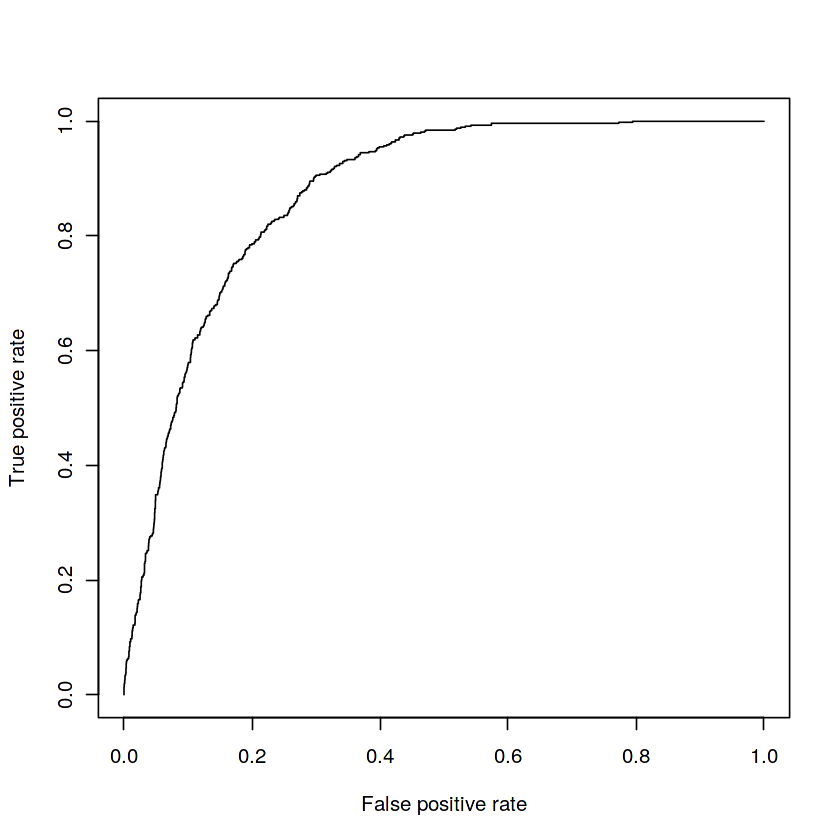

In [126]:
#source: https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it

library(ROCR)

p <- predict(dmodel, newdata=subset(test,select=c(1,2,3,4,5,6,7)), type="response")

pr <- prediction(p, test$dessert)

prf <- performance(pr, measure = "tpr", x.measure = "fpr")

plot(prf)

table(test$dessert, p>0.2) #https://medium.com/analytics-vidhya/a-guide-to-machine-learning-in-r-for-beginners-part-5-4c00f2366b90


#AUC, Area under the ROC curve, indicates the goodness of prediction when it's closer to 1.
auc <- performance(pr, measure = "auc")

auc <- auc@y.values[[1]]

auc
